# Masked Language Modelling and Sequence Classification with Bert
### HW3 @ DL Course, Dr. Soleymani

*Full Name:* Mehdi Jamalkhah

*SID:* ...

In this notebook, we leverage the "rotten_tomatoes" dataset from HuggingFace, containing movie reviews from Rotten Tomatoes. Our objectives are twofold:


1.   Perform Masked Language Modeling (MLM) on the training portion of provided dataset.
2.   Construct a classifier to discern between positive and negative reviews.

To achieve these goals, we employ a customized smaller version of BERT. This choice facilitates training and computation, ensuring efficiency and feasibility.

### Local Setup

In [ ]:
import gdown
VAR_ROOT = "vars/bert"
gdown.download_folder("https://drive.google.com/drive/folders/1Giz6bK4qOkDyhDFIZbPjSjm6WeabK_5t?usp=sharing", output=VAR_ROOT, quiet=True)

### Google Colab Setup

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'DL/HW3'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
os.chdir(GOOGLE_DRIVE_PATH)
print(os.listdir('./'))

### Save/Load

In [2]:
import torch
VAR_ROOT = "vars/bert"
def load(filename):
    return torch.load(VAR_ROOT + '/' + filename + '.pt', map_location=torch.device('cpu'))

def save(object, filename):
    filename = VAR_ROOT + '/' + filename + '.pt'
    if isinstance(object, torch.nn.Module):
        torch.save(object.state_dict(), filename)
    else:
        torch.save(object, filename)

In [2]:
# Install necessary packages
# %%capture
! pip install datasets
! pip install transformers
! pip install evaluate
! pip install accelerate -U

In [4]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt

In [5]:
# Set up basic configurations for training
batch_size = 32
learning_rate = 1e-5
num_epoch = 5
num_labels = 2
np.random.seed(42)
torch.manual_seed(42)

# Select device for training (GPU if available, otherwise CPU)
CUDA = "cuda"
device = CUDA if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Load the Rotten Tomatoes dataset
dataset = load_dataset('rotten_tomatoes')
dataset

In all subsequent sections, we utilize the pre-trained BERT tokenizer. Thus, we begin by importing and initializing it here.

In [4]:
# Import BertTokenizer from the transformers library
from transformers import BertTokenizer

# Load the pre-trained BertTokenizer model 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

We will utilize this configuration for the BERT model in subsequent sections.

In [8]:
# Import BertConfig from the transformers library
from transformers import BertConfig

# Define configuration parameters for the BERT model
config = BertConfig(
    hidden_size = 384,
    vocab_size= tokenizer.vocab_size,
    num_hidden_layers = 6,
    num_attention_heads = 6,
    intermediate_size = 1024,
    max_position_embeddings = 256
)

# 1 Masked Language Modeling

Masked Language Modeling (MLM) is a fundamental task in natural language processing (NLP) where a `head` is placed on top of a `BERT` (Bidirectional Encoder Representations from Transformers) model to `perform predictions`.
In MLM, certain words or tokens in a sentence are randomly masked or replaced with a special token, and the model is trained to predict the original words based on the context of the surrounding tokens. The objective of MLM is to encourage the model to learn contextual relationships between words and understand the overall structure and semantics of the language. During training, the model receives input sequences with masked tokens and is trained to generate the correct tokens for the masked positions. MLM serves as a crucial pre-training step in learning rich contextual representations of words, which can be transferred to downstream tasks such as text classification, named entity recognition, and question answering.

![](https://editor.analyticsvidhya.com/uploads/22971fig-3.png)

---

## 1.1 Dateset preparation for MLM

In [5]:
# Define a function to preprocess text data for masked language modeling (MLM)
def mlm_map_function(rows):
    # Tokenize the text with specified tokenizer parameters
    input_info = tokenizer(rows['text'], max_length=128, padding="max_length", truncation=True, return_tensors='pt')
    return {
        **input_info,
        'labels': input_info['input_ids']
        }

# Apply the mlm_map_function to the dataset for masked language modeling (MLM)
mlm_dataset = dataset.map(mlm_map_function, batched=True, num_proc=2, remove_columns=dataset['train'].column_names)

In [ ]:
# Import DataCollatorForLanguageModeling from transformers
from transformers import DataCollatorForLanguageModeling

# Create a data collator for MLM training
collate_fn = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# Create a DataLoader for MLM training
train_dataloader = torch.utils.data.DataLoader(
    mlm_dataset['train'],
    collate_fn=collate_fn,
    batch_size=batch_size
    )


## 1.2 BertModel + MLMHead + Custom trainer

In [ ]:
class MLMHead(nn.Module):
    """
    Multi-Layer Perceptron (MLP) head for Masked Language Modeling (MLM) task.

    Parameters:
        bert_model (torch.nn.Module): BERT model.
        hidden_size (int): Size of the hidden layers in the MLP head. Default is 384.
        vocab_size (int): Size of the vocabulary. Default is 30522.
    """

    def __init__(self, bert_model, hidden_size=384, vocab_size=30522):
        super(MLMHead, self).__init__()
        # construct layers and structure of the network
        self.embedder = bert_model
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.ReLU()
        self.layernorm = nn.LayerNorm(hidden_size)
        self.decoder = nn.Linear(hidden_size, vocab_size)

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the MLMHead module.

        Parameters:
            input_ids (torch.Tensor): Tensor containing input token IDs.
            attention_mask (torch.Tensor): Tensor containing attention mask.

        Returns:
            torch.Tensor: Output tensor of the MLM head.
        """
        # implement the forward pass of your model.
        # the sentence, the get the embeddings from your language
        # model, then use the `last_hidden_states` for your MLMHead
        # layer.
        out = self.embedder(input_ids, attention_mask)
        last_hidden_states = out.last_hidden_state

        out = self.dense(last_hidden_states)
        out = self.activation(out)
        out = self.layernorm(out)
        out = self.decoder(out)

        return out


In [ ]:
from transformers import BertModel
bert = BertModel(config)

In [ ]:
from transformers import BertModel

bert = BertModel(config).to(device)
mlm_model = MLMHead(bert).to(device)
optimizer = torch.optim.Adam(mlm_model.parameters(), lr=0.000008)
criterion = nn.CrossEntropyLoss()

In [ ]:
# implement your training loop and train your model.
losses = []
if device == CUDA:
    for epoch in range(num_epoch):
        mlm_model.train()
        for i, batch in enumerate(train_dataloader):
            for k, v in batch.items():
              batch[k] = v.to(device)
            output = mlm_model(batch['input_ids'], batch['attention_mask'])
            loss = criterion(output.permute(0, 2, 1), batch['labels'])
            loss.backward()
            optimizer.step()

            losses.append(loss)
            if i % 100 == 0 or i + 1 == len(train_dataloader):
              print(f"epoch({epoch+1}/{num_epoch})-iter({i+1}/{len(train_dataloader)}): loss: {loss: .4f}")

    save(losses, 'bert_losses')
else:
    losses = load('bert_losses')

epoch(1/5)-iter(1/267): loss:  10.4496
epoch(1/5)-iter(101/267): loss:  9.5764
epoch(1/5)-iter(201/267): loss:  8.7210
epoch(1/5)-iter(267/267): loss:  8.8144
epoch(2/5)-iter(1/267): loss:  8.6123
epoch(2/5)-iter(101/267): loss:  7.8927
epoch(2/5)-iter(201/267): loss:  7.7166
epoch(2/5)-iter(267/267): loss:  7.3112
epoch(3/5)-iter(1/267): loss:  7.6122
epoch(3/5)-iter(101/267): loss:  7.4383
epoch(3/5)-iter(201/267): loss:  7.0020
epoch(3/5)-iter(267/267): loss:  7.0410
epoch(4/5)-iter(1/267): loss:  7.2361
epoch(4/5)-iter(101/267): loss:  7.1953
epoch(4/5)-iter(201/267): loss:  7.0216
epoch(4/5)-iter(267/267): loss:  6.6561
epoch(5/5)-iter(1/267): loss:  7.1329
epoch(5/5)-iter(101/267): loss:  7.4653
epoch(5/5)-iter(201/267): loss:  6.8484
epoch(5/5)-iter(267/267): loss:  7.5051


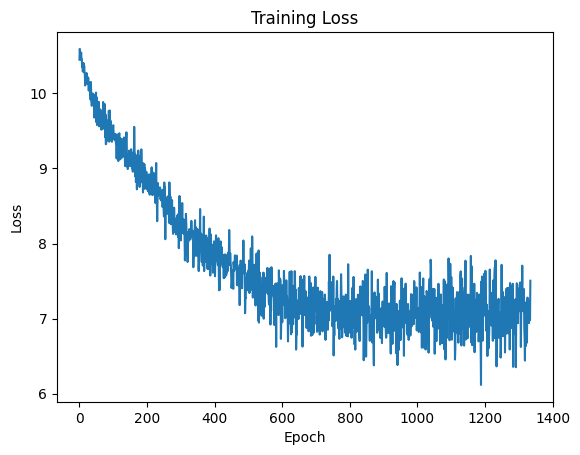

In [ ]:
# Plot the losse for every batch in training process
plt.plot([loss.detach().cpu() for loss in losses])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## 1.3 BertForMaskedLM + huggingface trainer

[HuggingFace library](http://huggingface.co/) has built a nice API for NLP tasks around the transformers. To get familiar with this comrehensive library, In this section you are asked to use the huggingface `Trainer`, `Dataset`, and `BertForMaskedLM` to do what we did above again.

Feel free to refer to the library documentation to learn about these modules.

You should utilize the prepared dataset and configuration from earlier.

In [ ]:
from transformers import BertForMaskedLM, Trainer, TrainingArguments
model = BertForMaskedLM(config)

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epoch,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=mlm_dataset['train'],
    eval_dataset=mlm_dataset['validation'],
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,6.838326
2,7.245100,4.403553
3,7.245100,2.838470
4,3.263100,1.991434
5,3.263100,1.736483


{'eval_loss': 1.7364829778671265,
 'eval_runtime': 2.0911,
 'eval_samples_per_second': 509.788,
 'eval_steps_per_second': 16.26,
 'epoch': 5.0}

# 2 Sequence Classification

When you look at how `BERT encodes` text, you'll see that it creates a `vector` for each word in the input sentence. But for basic classification tasks, we don't need all those individual word vectors.

Instead, we can just use the `first token's vector` because it captures the overall meaning of the sentence. BERT conveniently provides this vector for us in a special variable called `pooler_output`. So, in our classifier model, we'll use this pooler_output as the input for our classification head.

![BERT pooler output](https://miro.medium.com/max/1100/1*Or3YV9sGX7W8QGF83es3gg.webp)

## 2.1 Dataset preparation for sequence classification

In [6]:
# Define a function to preprocess text data for classification
def cls_map_function(rows):
    # Tokenize the text with specified tokenizer parameters
    input_info = tokenizer(rows['text'], truncation=True, max_length=128, padding=True)
    return {
        **input_info,
        'labels': rows['label']
        }

# Apply the cls_map_function to the dataset for classification
cls_dataset = dataset.map(cls_map_function, batched=True, num_proc=2, remove_columns=dataset['train'].column_names)

In [10]:
# Import DataCollatorWithPadding from transformers
from transformers import DataCollatorWithPadding

# Create a data collator with padding
col_fn = DataCollatorWithPadding(
    tokenizer, return_tensors='pt', padding='longest',
)

# Create a DataLoader for training data
train_loader = torch.utils.data.DataLoader(
    cls_dataset['train'],
    batch_size=batch_size,
    collate_fn=col_fn,
    shuffle=True
)

# Create a DataLoader for test data
test_loader = torch.utils.data.DataLoader(
    cls_dataset['test'],
    batch_size=batch_size,
    collate_fn=col_fn,
)

## 2.2 BertModel + ClassifierHead + Custom trainer

In [11]:
import torch
import torch.nn as nn

class ClassifierHead(nn.Module):
    """
    Classifier head for classification tasks.

    Parameters:
        embedding_model (torch.nn.Module): BERT model.
        num_classes (int): Number of classes for classification. Default is 2.
    """

    def __init__(self, embedding_model, num_classes=2):
        super().__init__()
        self.embedder = embedding_model
        self.classifier = nn.Linear(self.embedder.config.hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the ClassifierHead module.

        Parameters:
            input_ids (torch.Tensor): Tensor containing input token IDs.
            attention_mask (torch.Tensor): Tensor containing attention mask.

        Returns:
            torch.Tensor: Output tensor of the classifier head.
        """
        out = self.embedder(input_ids=input_ids, attention_mask=attention_mask)
        out = out.pooler_output  # [CLS] token representation
        out = self.classifier(out)
        out = self.sigmoid(out)

        return out

In [34]:
# Define the function to compute metrics
from transformers import BertModel
import evaluate
accuracy = evaluate.load("accuracy")

# Define the BERT model
bert = BertModel(config=config)

# Define the classifier head
cls_model = ClassifierHead(bert).to(device)
optimizer = torch.optim.Adam(cls_model.parameters(),  lr=0.00005)
criterion = nn.CrossEntropyLoss()

In [35]:
# implement your training loop and train your model.
history = {'train_loss': [], 'train_acc': []}
if device == CUDA:
    for epoch in range(num_epoch):
        cls_model.train()
        for i, batch in enumerate(train_loader):
            for k, v in batch.items():
              batch[k] = v.to(device)

            output = cls_model(batch['input_ids'], batch['attention_mask'])
            loss = criterion(output, batch['labels'])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            acc = output.max(1)[1].eq(batch['labels']).sum() / len(batch['input_ids'])
            history['train_acc'].append(acc)

            history['train_loss'].append(loss)
            if i % 100 == 0 or i + 1 == len(train_loader):
              print(f"epoch({epoch+1}/{num_epoch})-iter({i+1}/{len(train_loader)}): loss: {loss: .4f}; acc: {acc: .2f}")

    save(history, 'cls_history')
else:
    history = load('cls_history')

epoch(1/5)-iter(1/267): loss:  0.6932; acc:  0.50
epoch(1/5)-iter(101/267): loss:  0.6916; acc:  0.53
epoch(1/5)-iter(201/267): loss:  0.6921; acc:  0.56
epoch(1/5)-iter(267/267): loss:  0.6891; acc:  0.61
epoch(2/5)-iter(1/267): loss:  0.6922; acc:  0.50
epoch(2/5)-iter(101/267): loss:  0.6337; acc:  0.66
epoch(2/5)-iter(201/267): loss:  0.5629; acc:  0.75
epoch(2/5)-iter(267/267): loss:  0.5713; acc:  0.78
epoch(3/5)-iter(1/267): loss:  0.6097; acc:  0.69
epoch(3/5)-iter(101/267): loss:  0.5316; acc:  0.78
epoch(3/5)-iter(201/267): loss:  0.5358; acc:  0.78
epoch(3/5)-iter(267/267): loss:  0.4948; acc:  0.78
epoch(4/5)-iter(1/267): loss:  0.3550; acc:  0.97
epoch(4/5)-iter(101/267): loss:  0.4140; acc:  0.88
epoch(4/5)-iter(201/267): loss:  0.4129; acc:  0.88
epoch(4/5)-iter(267/267): loss:  0.4932; acc:  0.83
epoch(5/5)-iter(1/267): loss:  0.4629; acc:  0.84
epoch(5/5)-iter(101/267): loss:  0.4075; acc:  0.91
epoch(5/5)-iter(201/267): loss:  0.3641; acc:  0.94
epoch(5/5)-iter(267/26

In [47]:
corrects = 0
total = 0
with torch.no_grad():
  for betch in test_loader:
    for k, v in batch.items():
      batch[k] = v.to(device)
    output = cls_model(batch['input_ids'], batch['attention_mask'])
    corrects += output.max(1)[1].eq(batch['labels']).sum().item()
    total += len(batch['input_ids'])

print(f"Test acc: {corrects / total: .3f}")

Test acc:  0.944


## 2.3 BertForSequenceClassification + Hugginface Trainer

[HuggingFace library](http://huggingface.co/) has built a nice API for NLP tasks around the transformers. To get familiar with this comrehensive library, In this section you are asked to use the huggingface `Trainer`, `Dataset`, and `BertForSequenceClassification` to do what we did above again.

Feel free to refer to the library documentation to learn about these modules.

You should utilize the prepared dataset and configuration from earlier.(You can include any additional required attributes to configuration.)

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=78)

In [67]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, BertConfig
import numpy as np
from datasets import load_metric

# Load accuracy metric
accuracy_metric = load_metric("accuracy")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    return accuracy_metric.compute(predictions=preds, references=labels)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define the model configuration
config = BertConfig(
    hidden_size=384,
    vocab_size=tokenizer.vocab_size,
    num_hidden_layers=6,
    num_attention_heads=6,
    intermediate_size=1024,
    max_position_embeddings=256
)

# Initialize the model
model = BertForSequenceClassification(config)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=0.00004,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epoch,
    weight_decay=0.01
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=cls_dataset['train'],
    eval_dataset=cls_dataset['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.646872,0.636961
2,0.626000,0.532053,0.736398
3,0.626000,0.590249,0.743902
4,0.379800,0.566833,0.753283
5,0.379800,0.579022,0.757974


TrainOutput(global_step=1335, training_loss=0.44947756077912865, metrics={'train_runtime': 89.4194, 'train_samples_per_second': 476.966, 'train_steps_per_second': 14.93, 'total_flos': 168105418173840.0, 'train_loss': 0.44947756077912865, 'epoch': 5.0})

In [68]:
# Evaluate the model
trainer.evaluate(cls_dataset['test'])

{'eval_loss': 0.5426440238952637,
 'eval_accuracy': 0.776735459662289,
 'eval_runtime': 0.7242,
 'eval_samples_per_second': 1472.041,
 'eval_steps_per_second': 46.951,
 'epoch': 5.0}